# Import Data and Packages

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from skopt import BayesSearchCV
from datetime import datetime
from datetime import timedelta  
import gc


In [49]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

def process_sales_data(sales, calendar, sell_prices, dept_filter=None):
    """
    Process sales data by splitting identifiers, reshaping the data, 
    handling missing values, and creating relevant features.
    
    Parameters:
    sales (pd.DataFrame): The sales dataset containing item and store information.
    calendar (pd.DataFrame): The calendar dataset with event and date information.
    sell_prices (pd.DataFrame): The sell prices dataset.
    dept_filter (str, optional): The department ID to filter the sales data. If None, no filtering is applied.
    
    Returns:
    pd.DataFrame: Processed sales data.
    """
    
    # Split 'id' into multiple columns
    sales[['dept', 'item', 'store', 'dataset_type']] = sales['id'].str.split('_', n=3, expand=True)
    
    # Filter by department if specified
    if dept_filter:
        sales = sales[sales['dept_id'] == dept_filter].copy()
    
    # Add missing columns for specific days (from 1942 to 1969)
    for i in range(1942, 1970):
        sales[f'd_{i}'] = 0
    
    # Reshape data from wide to long format
    sales_by_date = pd.melt(
        sales,
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        var_name='d',
        value_name='items_sold'
    ).merge(calendar, on='d', how='left') \
     .merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    
    # Keep only relevant columns
    sales_by_date = sales_by_date[['id', 'date', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
                                   'items_sold', 'weekday', 'wday', 'month', 'year', 'event_name_1', 
                                   'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 
                                   'snap_TX', 'snap_WI', 'sell_price']]
    
    # Process event name features
    sales_by_date['event_1_isna'] = sales_by_date['event_name_1'].notna().astype(int)
    sales_by_date['event_2_isna'] = sales_by_date['event_name_2'].notna().astype(int)
    sales_by_date['num_events'] = sales_by_date['event_1_isna'] + sales_by_date['event_2_isna']
    
    sales_by_date['event_name_1'] = sales_by_date['event_name_1'].fillna('no_event')
    sales_by_date['event_name_2'] = sales_by_date['event_name_2'].fillna('no_event')
    
    # Process SNAP features
    sales_by_date.loc[sales_by_date['state_id'] == 'CA', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'CA', 'snap_CA']
    sales_by_date.loc[sales_by_date['state_id'] == 'TX', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'TX', 'snap_TX']
    sales_by_date.loc[sales_by_date['state_id'] == 'WI', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'WI', 'snap_WI']
    
    sales_by_date['snap'] = sales_by_date['snap'].fillna(0).astype(int)
    
    # Add weekend feature
    sales_by_date['is_weekend'] = (sales_by_date['wday'] <= 2).astype(int)
    
    # Date format
    sales_by_date['date'] = pd.to_datetime(sales_by_date['date'])

    return sales_by_date

def rolling_updates(df, date):
    """
    Update lag/rolling features for one day only.
    
    This function is used for submission creation when predictions for multiple days
    are performed recursively. It aligns with the code that uses a reset-index, groupby,
    and rolling window approach.
    
    Parameters:
      df (DataFrame): Input DataFrame that should contain at least the following columns:
                      'id', 'date', 'store_id', 'item_id', 'items_sold', 'sell_price'.
      date (datetime): The date for which the features should be updated.
    
    Returns:
      DataFrame: The original DataFrame with new rolling feature columns updated for rows matching `date`.
    """
    from datetime import timedelta
    import pandas as pd
    
    # Ensure numeric types for key columns
    df['items_sold'] = pd.to_numeric(df['items_sold'], errors='coerce').astype('float32')
    df['sell_price'] = pd.to_numeric(df['sell_price'], errors='coerce').astype('float32')
    
    # Create a working copy and set/reset index for grouping convenience
    temp = df.copy()
    temp = temp.set_index(['id', 'date'])
    temp_reset = temp.reset_index()
    
    # Define the aggregation list (each item defines a rolling aggregation to compute)
    agg_list = [
        [['store_id', 'item_id'], 'items_sold', 'mean', [1], [7, 14, 3, 60, 90, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]],
        [['store_id', 'item_id'], 'items_sold', 'mean', [7], [7, 365]],
        [['store_id', 'item_id'], 'items_sold', 'mean', [7, 14, 30, 60, 180], [28]],
        [['store_id', 'item_id'], 'items_sold', 'std',  [7, 14, 30, 60, 180], [28]],
        [['store_id', 'item_id'], 'sell_price', 'max', [365], [1]],
        [['store_id', 'item_id'], 'sell_price', 'mean', [7], [1]],
        [['store_id', 'item_id'], 'items_sold', 'std', [90], [1]],    
        [['store_id', 'item_id'], 'items_sold', 'std', [30], [1]],    
        [['store_id', 'item_id'], 'items_sold', 'std', [328], [1]],   
        [['store_id', 'item_id'], 'items_sold', 'std', [60], [1]],     
    ]
    
    # For each aggregation, compute the rolling statistic (after sorting by date) and shift by the lag value.
    for item in agg_list:
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
            for rolling_window in rolling_windows:
                col_name = f"{agg_function}_{target_col}_per_{groupby_col_str}_r{rolling_window}_lag_{lag}"
                computed = temp_reset.groupby(groupby_cols, group_keys=False).apply(
                    lambda g: g.sort_values('date')[target_col]
                              .rolling(window=rolling_window)
                              .agg(agg_function)
                              .shift(lag)
                )
                temp_reset[col_name] = computed
    
    # Reconstruct the DataFrame with a multi-index (id, date) for easy extraction
    temp_final = temp_reset.set_index(['id', 'date'])
    
    # Determine which new columns were created (i.e. those not already in df)
    new_cols = [col for col in temp_final.columns if col not in df.columns]
    
    # Update the original dataframe's rows for the given date with the new features.
    # Here we assume 'id' uniquely identifies rows.
    # For each new column, we assign values from temp_final for rows with the matching date.
    for col in new_cols:
        # Build a mask for rows corresponding to the given date.
        # We use .loc on the multi-index; slice(None) for id means all ids.
        try:
            df.loc[df['date'] == date, col] = temp_final.loc[(slice(None), date), col].values
        except Exception as e:
            print(f"Error updating column {col}: {e}")
    
    # Optionally, update derived features if the required columns exist.
    if ('max_sell_price_per_store_id_item_id_r365_lag_1' in df.columns and
        'mean_sell_price_per_store_id_item_id_r7_lag_1' in df.columns):
        mask = (df['date'] == date)
        df.loc[mask, 'sell_price_norm'] = df.loc[mask, 'sell_price'] / df.loc[mask, 'max_sell_price_per_store_id_item_id_r365_lag_1']
        df.loc[mask, 'sell_price_momentum'] = df.loc[mask, 'sell_price'] / df.loc[mask, 'mean_sell_price_per_store_id_item_id_r7_lag_1']
    
    return df


In [50]:
calendar = pd.read_csv('calendar.csv').pipe(reduce_mem_usage, verbose=True)
calendar['date'] = pd.to_datetime(calendar['date'])
sales = pd.read_csv('sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)
sell_prices = pd.read_csv('sell_prices.csv').pipe(reduce_mem_usage, verbose=True)
hobbies_sales_by_date = process_sales_data(sales, calendar, sell_prices, dept_filter="HOBBIES_1")
hobbies_sales_by_date.shape

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.61 Mb (78.9% reduction)
Mem. usage decreased to 143.53 Mb (31.2% reduction)


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\2038590429.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales[['dept', 'item', 'store', 'dataset_type']] = sales['id'].str.split('_', n=3, expand=True)
C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\2038590429.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales[['dept', 'item', 'store', 'dataset_type']] = sales['id'].str.split('_', n=3, expand=True)
C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\2038590429.py:42: PerformanceWarning: DataFrame is highly fragme

(8207680, 25)

In [51]:
import gc
del calendar, sell_prices, sales
gc.collect()

31

# Feature Engineering

## Create Rolling Features and Lags

In [2]:
"""
Grouping and Sorting
The data is first grouped by store_id and item_id. Within each group, the data is sorted by date to ensure the correct time series order.

Calculating Rolling Statistics
Within each group, rolling statistics (e.g., mean or standard deviation) are computed for the target variable (such as items_sold or sell_price) using a specified window size (e.g., 3 days, 7 days, 14 days, etc.).

Applying Lag (Shift)
After calculating the rolling statistics, a shift (lag) operation is applied to the results. This ensures that statistical features from previous time points are used while excluding data from the current day.

Merging the Results
To handle potential duplicate (id, date) values, the index is reset to ensure uniqueness for each row. Finally, the computed results are merged back into the original DataFrame based on the corresponding rows.
"""

'\nGrouping and Sorting\nThe data is first grouped by store_id and item_id. Within each group, the data is sorted by date to ensure the correct time series order.\n\nCalculating Rolling Statistics\nWithin each group, rolling statistics (e.g., mean or standard deviation) are computed for the target variable (such as items_sold or sell_price) using a specified window size (e.g., 3 days, 7 days, 14 days, etc.).\n\nApplying Lag (Shift)\nAfter calculating the rolling statistics, a shift (lag) operation is applied to the results. This ensures that statistical features from previous time points are used while excluding data from the current day.\n\nMerging the Results\nTo handle potential duplicate (id, date) values, the index is reset to ensure uniqueness for each row. Finally, the computed results are merged back into the original DataFrame based on the corresponding rows.\n'

In [ ]:
temp = hobbies_sales_by_date.copy()

temp['items_sold'] = pd.to_numeric(temp['items_sold'], errors='coerce')
temp['sell_price'] = pd.to_numeric(temp['sell_price'], errors='coerce')
temp['items_sold'] = pd.to_numeric(temp['items_sold'], errors='coerce').astype('float32')
temp['sell_price'] = pd.to_numeric(temp['sell_price'], errors='coerce').astype('float32')


temp = temp.set_index(['id', 'date'])
temp_reset = temp.reset_index()

agg_list = [
    [['store_id', 'item_id'], 'items_sold', 'mean', [1], [7, 14, 3, 60, 90, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]],
    [['store_id', 'item_id'], 'items_sold', 'mean', [7], [7, 365]],
    [['store_id', 'item_id'], 'items_sold', 'mean', [7, 14, 30, 60, 180], [28]],
    [['store_id', 'item_id'], 'items_sold', 'std',  [7, 14, 30, 60, 180], [28]],
    [['store_id', 'item_id'], 'sell_price', 'max', [365], [1]],
    [['store_id', 'item_id'], 'sell_price', 'mean', [7], [1]],
    [['store_id', 'item_id'], 'items_sold', 'std', [90], [1]],    
    [['store_id', 'item_id'], 'items_sold', 'std', [30], [1]],    
    [['store_id', 'item_id'], 'items_sold', 'std', [328], [1]],   
    [['store_id', 'item_id'], 'items_sold', 'std', [60], [1]],     
]

for item in agg_list:
    groupby_cols, target_col, agg_function, rolling_windows, lags = item
    groupby_col_str = "_".join(groupby_cols)
    
    for lag in lags:
        for rolling_window in rolling_windows:
            col_name = f"{agg_function}_{target_col}_per_{groupby_col_str}_r{rolling_window}_lag_{lag}"
            computed = temp_reset.groupby(groupby_cols, group_keys=False).apply(
                lambda g: g.sort_values('date')[target_col]
                          .rolling(window=rolling_window)
                          .agg(agg_function)
                          .shift(lag)
            )
            temp_reset[col_name] = computed

temp_final = temp_reset.set_index(['id', 'date'])

In [6]:
temp_final.to_pickle('temp_final.pkl')

In [54]:
temp_final = pd.read_pickle('temp_final.pkl')
temp_final['sell_price_norm'] = temp_final['sell_price'] / temp_final['max_sell_price_per_store_id_item_id_r365_lag_1']
temp_final['sell_price_momentum'] = temp_final['sell_price'] / temp_final['mean_sell_price_per_store_id_item_id_r7_lag_1']

In [55]:
# add column to capture more nuances
temp_final['is_saturday'] = (temp_final['weekday'] == 'Saturday').astype(int)

In [56]:
hobbies_sales_by_date = temp_final.copy()
del temp_final
import gc
gc.collect()

3911

## Handling Categorical Features

In [57]:
from sklearn.preprocessing import LabelEncoder
cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

for col in cat_features:
    le = LabelEncoder()
    hobbies_sales_by_date[col+'_label'] = le.fit_transform(hobbies_sales_by_date[col])

In [58]:
hobbies_sales_by_date = reduce_mem_usage(hobbies_sales_by_date, verbose=True)
hobbies_sales_by_date.to_pickle("hobbies_sales_by_date.pkl")

Mem. usage decreased to 2254.48 Mb (42.9% reduction)


In [64]:

unused_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','items_sold','weekday','year','event_name_1','event_type_1',
              'event_name_2','event_type_2','snap_CA','snap_TX','snap_WI','event_1_isna','event_2_isna']

feature_cols = list(set(hobbies_sales_by_date.columns) - set(unused_cols))
label_col = ['items_sold']

In [65]:
hobbies_sales_by_date.dropna(subset=feature_cols, inplace=True) # drop NAs; items sold are 0 because of out-of-stock or not-sold-anymore

In [66]:
hobbies_sales_by_date.to_pickle("hobbies_sales_by_date.pkl")

In [67]:
# Assume feature_cols is your list of feature columns
if 'is_saturday' in feature_cols:
    print("is_saturday exists in feature_cols")
else:
    print("is_saturday does not exist in feature_cols")

is_saturday exists in feature_cols


In [68]:
hobbies_sales_by_date

,,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_14,mean_items_sold_per_store_id_item_id_r1_lag_3,mean_items_sold_per_store_id_item_id_r1_lag_60,mean_items_sold_per_store_id_item_id_r1_lag_90,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,std_items_sold_per_store_id_item_id_r90_lag_1,std_items_sold_per_store_id_item_id_r30_lag_1,std_items_sold_per_store_id_item_id_r328_lag_1,std_items_sold_per_store_id_item_id_r60_lag_1,sell_price_norm,sell_price_momentum,is_saturday,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label
id,date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_008_CA_1_evaluation,2012-02-04,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,16.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,0.50,0,0,0,1,1,18.0,20.0,12.0,2.0,7.0,7.0,29.0,7.0,6.0,30.0,4.0,0.0,9.0,14.0,3.0,7.0,30.0,0.0,0.0,8.0,10.714286,5.285714,11.857142,10.428572,11.066667,10.533334,9.050000,12.294017,11.105884,11.113625,10.778929,9.578418,0.50,0.50,9.941960,8.623677,8.815365,10.899373,1.000000,1.0,1,7,0,0,0,0
HOBBIES_1_009_CA_1_evaluation,2012-02-04,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,0.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,1.77,0,0,0,1,1,0.0,1.0,2.0,2.0,0.0,4.0,1.0,0.0,3.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,0.0,8.0,0.571429,2.428571,2.142857,1.714286,2.300000,2.000000,1.561111,1.573592,1.382783,1.932481,2.239855,2.000458,1.77,1.77,2.540459,3.070812,2.456330,2.572124,1.000000,1.0,1,8,0,0,0,0
HOBBIES_1_010_CA_1_evaluation,2012-02-04,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,2.97,0,0,0,1,1,2.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.142857,0.285714,0.285714,0.566667,0.600000,0.777778,0.487950,0.468807,0.727932,0.763578,0.924862,3.17,2.97,0.831946,0.899553,0.856793,0.836153,0.936908,1.0,1,9,0,0,0,0
HOBBIES_1_012_CA_1_evaluation,2012-02-04,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,2.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,6.52,0,0,0,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.285714,0.285714,0.428571,0.642857,0.533333,0.633333,0.566667,0.786796,0.744946,0.681445,0.758381,0.762970,6.52,6.52,0.719707,0.621455,0.756853,0.650945,1.000000,1.0,1,11,0,0,0,0
HOBBIES_1_015_CA_1_evaluation,2012-02-04,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,13.0,Saturday,1.0

## Train Test Split

In [69]:
hobbies_sales_by_date.reset_index(inplace=True)
hobbies_sales_by_date.set_index('date', inplace=True)
hobbies_sales_by_date.drop(columns='id', inplace=True)
hobbies_sales_by_date.head()

,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_14,mean_items_sold_per_store_id_item_id_r1_lag_3,mean_items_sold_per_store_id_item_id_r1_lag_60,mean_items_sold_per_store_id_item_id_r1_lag_90,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,std_items_sold_per_store_id_item_id_r90_lag_1,std_items_sold_per_store_id_item_id_r30_lag_1,std_items_sold_per_store_id_item_id_r328_lag_1,std_items_sold_per_store_id_item_id_r60_lag_1,sell_price_norm,sell_price_momentum,is_saturday,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-02-04,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,16.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,0.50,0,0,0,1,1,18.0,20.0,12.0,2.0,7.0,7.0,29.0,7.0,6.0,30.0,4.0,0.0,9.0,14.0,3.0,7.0,30.0,0.0,0.0,8.0,10.714286,5.285714,11.857142,10.428572,11.066667,10.533334,9.050000,12.294017,11.105884,11.113625,10.778929,9.578418,0.50,0.50,9.941960,8.623677,8.815365,10.899373,1.000000,1.0,1,7,0,0,0,0
2012-02-04,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,0.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,1.77,0,0,0,1,1,0.0,1.0,2.0,2.0,0.0,4.0,1.0,0.0,3.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,0.0,8.0,0.571429,2.428571,2.142857,1.714286,2.300000,2.000000,1.561111,1.573592,1.382783,1.932481,2.239855,2.000458,1.77,1.77,2.540459,3.070812,2.456330,2.572124,1.000000,1.0,1,8,0,0,0,0
2012-02-04,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,2.97,0,0,0,1,1,2.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.142857,0.285714,0.285714,0.566667,0.600000,0.777778,0.487950,0.468807,0.727932,0.763578,0.924862,3.17,2.97,0.831946,0.899553,0.856793,0.836153,0.936908,1.0,1,9,0,0,0,0
2012-02-04,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,2.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,6.52,0,0,0,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.285714,0.285714,0.428571,0.642857,0.533333,0.633333,0.566667,0.786796,0.744946,0.681445,0.758381,0.762970,6.52,6.52,0.719707,0.621455,0.756853,0.650945,1.000000,1.0,1,11,0,0,0,0
2012-02-04,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,13.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,0.72,0,0,0,1,1,7.0,15.0,2.0,3.0,8.0,14.0,30.0,3.0,9.0,0.0,0.0,0.0,0.0,7.0,8.0,7.0,7.0,3.0,0.0,15.0,6.571

In [ ]:
train_end_date = '2016-04-24'
test_start_date = '2016-04-24'
test_end_date = '2016-05-22'

X_train = hobbies_sales_by_date.loc[ : train_end_date][feature_cols]
y_train = hobbies_sales_by_date.loc[ : train_end_date][label_col]

X_test = hobbies_sales_by_date.loc[test_start_date : test_end_date][feature_cols]
y_test = hobbies_sales_by_date.loc[test_start_date : test_end_date][label_col]

In [71]:
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")
X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

In [72]:
gc.collect()

0

# Bayseian Hyperparameter Tuning

In [98]:
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("y_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

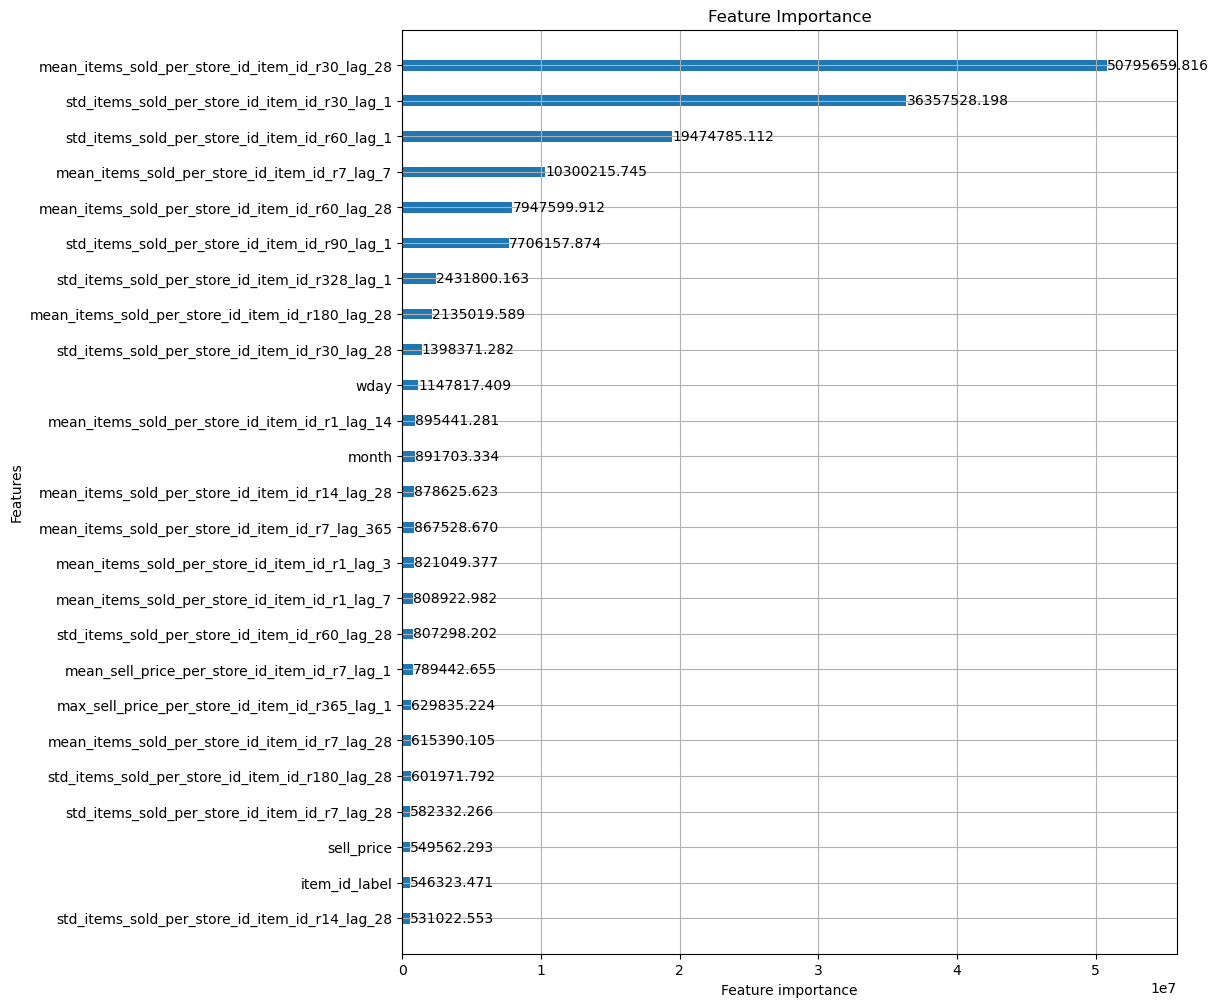

In [99]:
best_p = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'num_iterations': 1437,       
    'metric': 'rmse',
    'num_leaves': 452,
    'max_depth': 26,
    'learning_rate': 0.02377,
    'feature_fraction': 0.5044,
    'bagging_fraction': 0.95903,
    'min_data_in_leaf': 185
}

best_m = lgb.LGBMRegressor(**best_p)

best_m.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

ax = lgb.plot_importance(
    best_m,
    max_num_features=25,
    importance_type='gain',
    title='Feature Importance',
    figsize=(10, 12),
    grid=True,
    height=0.3
)
plt.show()


In [75]:
gc.collect()

37

# Model Train and Prediction

In [76]:
hobbies_sales_by_date = pd.read_pickle("hobbies_sales_by_date.pkl")
hobbies_sales_by_date['items_sold_true'] = hobbies_sales_by_date['items_sold']
hobbies_sales_by_date.reset_index(inplace=True)

In [78]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

test_start_date = '2016-04-24'
scaling_factor = 1.0  # a scaling factor that adjusts every score prediction
start_date = datetime(2016, 4, 24)
num_dates = 28

for i in range(num_dates):
    date = start_date + timedelta(days=i)
    print(date)
    
    # compute the features on-the-fly because some features depend on predictions
    X_features = rolling_updates(hobbies_sales_by_date, date=date)

    X_pred = X_features[X_features['date'] == date][feature_cols]

    # generate predictions
    y_pred = best_m.predict(X_pred) * scaling_factor

    # y_pred[y_pred <= threshold] = 0
    
    # update predictions to the sales_by_date dataframe
    hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-04-24 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-25 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06483172 0.26928358 0.70809565 ... 0.13390385 0.40939395 0.36724866]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-26 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.82514005 0.16506202 0.5004938  ... 0.10649362 0.34008681 0.28004867]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-27 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.76062123 0.15056409 0.46050366 ... 0.10990406 0.3498671  0.28215119]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-28 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.78351113 0.18520563 0.49225501 ... 0.09861573 0.34211029 0.26124579]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-29 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.78748381 0.16269918 0.45884172 ... 0.09851138 0.40279169 0.26292942]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-04-30 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90856406 0.21448445 0.60048059 ... 0.12388651 0.44428467 0.35107753]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-01 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.12054579 0.25077972 0.74380845 ... 0.14075593 0.48804022 0.40096201]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-02 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.01888546 0.24248947 0.70797207 ... 0.12222234 0.41218458 0.30887843]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-03 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.81775782 0.18965813 0.46776311 ... 0.09056319 0.33556699 0.22711306]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-04 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.76946742 0.16843424 0.44806209 ... 0.08806799 0.33198974 0.25030733]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-05 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.68317792 0.17179044 0.47531462 ... 0.09563499 0.3388619  0.25457319]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-06 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.83207093 0.19197361 0.42531468 ... 0.09334311 0.32733816 0.24306316]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-07 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.83418981 0.22346841 0.50559786 ... 0.12067252 0.41993139 0.2924908 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-08 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.28801497 0.32509471 0.73147426 ... 0.13318869 0.41975505 0.35800701]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-09 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.20220736 0.27242059 0.64048302 ... 0.12330068 0.36277714 0.31337476]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-10 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90109243 0.20656893 0.45243491 ... 0.09602294 0.35148595 0.22930647]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-11 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8723464  0.18242736 0.46098168 ... 0.09370395 0.29539732 0.23184836]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-12 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.85456178 0.17975164 0.44966188 ... 0.08796473 0.31728141 0.26155173]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.93249186 0.17782808 0.45658203 ... 0.08664053 0.29449524 0.23141672]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-13 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.93920573 0.20509478 0.53845127 ... 0.09794512 0.3437907  0.24416866]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-14 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.35335134 0.25180543 0.8220938  ... 0.11764672 0.33914192 0.32609542]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-15 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-16 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.18532019 0.27307893 0.78117528 ... 0.10651419 0.36671693 0.28825888]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-17 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.86703271 0.23483423 0.52765232 ... 0.08284072 0.29982815 0.22040576]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.79531085 0.239092   0.47154581 ... 0.0687938  0.29587378 0.21378006]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-18 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.87487842 0.25741433 0.52387918 ... 0.07375279 0.27128493 0.20486397]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-19 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.86484325 0.24767719 0.50639593 ... 0.0692609  0.33386826 0.19792573]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


2016-05-20 00:00:00
[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903
2016-05-21 00:00:00


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.97530916 0.2886565  0.66559358 ... 0.07375593 0.40297136 0.26046343]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\3151092681.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.5333947  0.37842573 0.85796656 ... 0.11503676 0.39676031 0.32100641]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hobbies_sales_by_date.loc[hobbies_sales_by_date['date'] == date, 'items_sold'] = y_pred


In [ ]:
# newwbs = hobbies_sales_by_date
# newwbs.to_pickle('newwbs.pkl')

In [100]:
y_train_pred = best_m.predict(X_train)

[LightGBM] [Warning] min_data_in_leaf is set=185, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=185
[LightGBM] [Warning] feature_fraction is set=0.5044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5044
[LightGBM] [Warning] bagging_fraction is set=0.95903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95903


In [101]:
hobbies_sales_by_date = pd.read_pickle('newwbs.pkl')
update_train_pred = hobbies_sales_by_date
update_train_pred

,id,date,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_14,mean_items_sold_per_store_id_item_id_r1_lag_3,mean_items_sold_per_store_id_item_id_r1_lag_60,mean_items_sold_per_store_id_item_id_r1_lag_90,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,std_items_sold_per_store_id_item_id_r90_lag_1,std_items_sold_per_store_id_item_id_r30_lag_1,std_items_sold_per_store_id_item_id_r328_lag_1,std_items_sold_per_store_id_item_id_r60_lag_1,sell_price_norm,sell_price_momentum,is_saturday,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label,items_sold_true
0,HOBBIES_1_008_CA_1_evaluation,2012-02-04,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,16.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,0.50,0,0,0,1,1,18.0,20.0,12.0,2.0,7.0,7.0,29.0,7.0,6.0,30.0,4.0,0.0,9.0,14.0,3.0,7.0,30.0,0.0,0.0,8.0,10.714286,5.285714,11.857142,10.428572,11.066667,10.533334,9.050000,12.294017,11.105884,11.113625,10.778929,9.578418,0.50,0.50,9.941960,8.623677,8.815365,10.899373,1.000000,1.0,1,7,0,0,0,0,16.0
1,HOBBIES_1_009_CA_1_evaluation,2012-02-04,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,0.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,1.77,0,0,0,1,1,0.0,1.0,2.0,2.0,0.0,4.0,1.0,0.0,3.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,0.0,8.0,0.571429,2.428571,2.142857,1.714286,2.300000,2.000000,1.561111,1.573592,1.382783,1.932481,2.239855,2.000458,1.77,1.77,2.540459,3.070812,2.456330,2.572124,1.000000,1.0,1,8,0,0,0,0,0.0
2,HOBBIES_1_010_CA_1_evaluation,2012-02-04,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,2.97,0,0,0,1,1,2.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.142857,0.285714,0.285714,0.566667,0.600000,0.777778,0.487950,0.468807,0.727932,0.763578,0.924862,3.17,2.97,0.831946,0.899553,0.856793,0.836153,0.936908,1.0,1,9,0,0,0,0,1.0
3,HOBBIES_1_012_CA_1_evaluation,2012-02-04,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,2.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,6.52,0,0,0,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.285714,0.285714,0.428571,0.642857,0.533333,0.633333,0.566667,0.786796,0.744946,0.681445,0.758381,0.762970,6.52,6.52,0.719707,0.621455,0.756853,0.650945,1.000000,1.0,1,11,0,0,0,0,2.0
4,HOBBIES_1_015_CA_1_evaluation,2012-02-04,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,13.0,Saturday,1.0,2.0,2012.0,no_event,NaN,no

In [103]:
len(y_train_pred)

4941301

In [ ]:
update_train_pred['items_sold']

In [104]:
update_train_pred.iloc[:len(y_train_pred), update_train_pred.columns.get_loc('items_sold')] = y_train_pred
update_train_pred

,id,date,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_14,mean_items_sold_per_store_id_item_id_r1_lag_3,mean_items_sold_per_store_id_item_id_r1_lag_60,mean_items_sold_per_store_id_item_id_r1_lag_90,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,std_items_sold_per_store_id_item_id_r90_lag_1,std_items_sold_per_store_id_item_id_r30_lag_1,std_items_sold_per_store_id_item_id_r328_lag_1,std_items_sold_per_store_id_item_id_r60_lag_1,sell_price_norm,sell_price_momentum,is_saturday,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label,items_sold_true
0,HOBBIES_1_008_CA_1_evaluation,2012-02-04,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,13.079786,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,0.50,0,0,0,1,1,18.0,20.0,12.0,2.0,7.0,7.0,29.0,7.0,6.0,30.0,4.0,0.0,9.0,14.0,3.0,7.0,30.0,0.0,0.0,8.0,10.714286,5.285714,11.857142,10.428572,11.066667,10.533334,9.050000,12.294017,11.105884,11.113625,10.778929,9.578418,0.50,0.50,9.941960,8.623677,8.815365,10.899373,1.000000,1.0,1,7,0,0,0,0,16.0
1,HOBBIES_1_009_CA_1_evaluation,2012-02-04,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2.490724,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,1.77,0,0,0,1,1,0.0,1.0,2.0,2.0,0.0,4.0,1.0,0.0,3.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,1.0,1.0,0.0,8.0,0.571429,2.428571,2.142857,1.714286,2.300000,2.000000,1.561111,1.573592,1.382783,1.932481,2.239855,2.000458,1.77,1.77,2.540459,3.070812,2.456330,2.572124,1.000000,1.0,1,8,0,0,0,0,0.0
2,HOBBIES_1_010_CA_1_evaluation,2012-02-04,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0.997841,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,2.97,0,0,0,1,1,2.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,0.142857,0.285714,0.285714,0.566667,0.600000,0.777778,0.487950,0.468807,0.727932,0.763578,0.924862,3.17,2.97,0.831946,0.899553,0.856793,0.836153,0.936908,1.0,1,9,0,0,0,0,1.0
3,HOBBIES_1_012_CA_1_evaluation,2012-02-04,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,0.716471,Saturday,1.0,2.0,2012.0,no_event,NaN,no_event,NaN,1.0,0.0,0.0,6.52,0,0,0,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.285714,0.285714,0.428571,0.642857,0.533333,0.633333,0.566667,0.786796,0.744946,0.681445,0.758381,0.762970,6.52,6.52,0.719707,0.621455,0.756853,0.650945,1.000000,1.0,1,11,0,0,0,0,2.0
4,HOBBIES_1_015_CA_1_evaluation,2012-02-04,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,12.523764,Saturday,1.0,2

C:\Users\wxiny\AppData\Local\Temp\ipykernel_34480\1671263971.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['items_sold'] = test_df['items_sold'] * scaling_factor


RMSE: 248.058624934809
MAE: 181.6812588518316
MAPE: 4.919726172332022%
sMAPE: 4.9060365943096995%


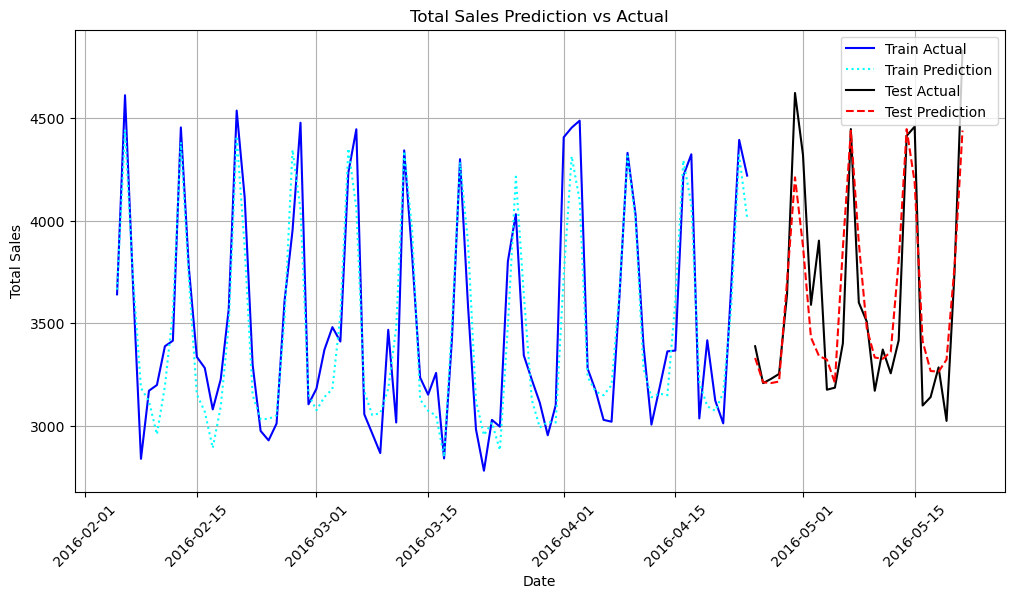

In [105]:
# Scaling factor
scaling_factor = 1.037

# Split data into train and test
train_df = update_train_pred[update_train_pred['date'] < '2016-04-25']
test_df = update_train_pred[(update_train_pred['date'] >= '2016-04-25') & (update_train_pred['date'] <= '2016-05-21')]

# Apply scaling factor to predictions
test_df['items_sold'] = test_df['items_sold'] * scaling_factor

# Aggregate sales by date
train_actual = train_df.groupby('date').agg({'items_sold_true': 'sum'}).reset_index()
train_pred = train_df.groupby('date').agg({'items_sold': 'sum'}).reset_index()
test_actual = test_df.groupby('date').agg({'items_sold_true': 'sum'}).reset_index()
test_pred = test_df.groupby('date').agg({'items_sold': 'sum'}).reset_index()

# Convert date columns to datetime format
train_actual['date'] = pd.to_datetime(train_actual['date'])
train_pred['date'] = pd.to_datetime(train_pred['date'])
test_actual['date'] = pd.to_datetime(test_actual['date'])
test_pred['date'] = pd.to_datetime(test_pred['date'])

# Set index for merging
train_actual.set_index('date', inplace=True)
train_pred.set_index('date', inplace=True)
test_actual.set_index('date', inplace=True)
test_pred.set_index('date', inplace=True)

# Merge actual and predicted for error calculations
df_merged = test_actual.join(test_pred, how='inner')
errors = df_merged['items_sold_true'] - df_merged['items_sold']

# Compute error metrics
rmse = np.sqrt(np.mean(errors**2))
mae = np.mean(np.abs(errors))
mape = np.mean(np.abs(errors / df_merged['items_sold_true'])) * 100
smape = 100 * np.mean(2 * np.abs(errors) / (np.abs(df_merged['items_sold_true']) + np.abs(df_merged['items_sold'])))

# Print error metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"sMAPE: {smape}%")

# Plot with required formatting
plt.figure(figsize=(12, 6))
plt.plot(train_actual.index[-80:], train_actual['items_sold_true'][-80:], label="Train Actual", color="blue")
plt.plot(train_pred.index[-80:], train_pred['items_sold'][-80:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test_actual.index, test_actual['items_sold_true'], label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred['items_sold'], label="Test Prediction", linestyle="dashed", color="red")

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


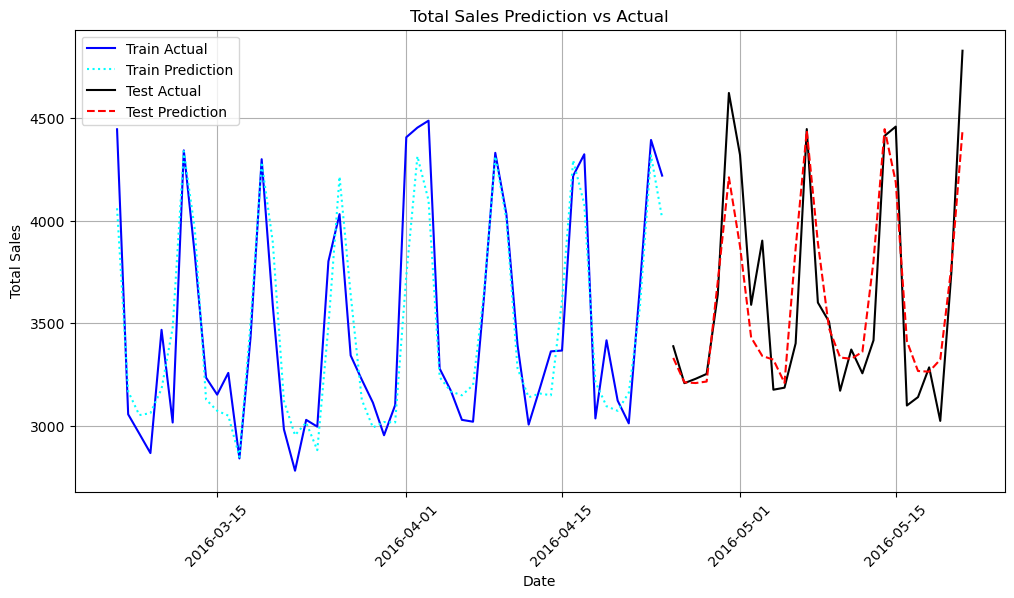

In [106]:
# Plot with required formatting
plt.figure(figsize=(12, 6))
plt.plot(train_actual.index[-50:], train_actual['items_sold_true'][-50:], label="Train Actual", color="blue")
plt.plot(train_pred.index[-50:], train_pred['items_sold'][-50:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test_actual.index, test_actual['items_sold_true'], label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred['items_sold'], label="Test Prediction", linestyle="dashed", color="red")

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


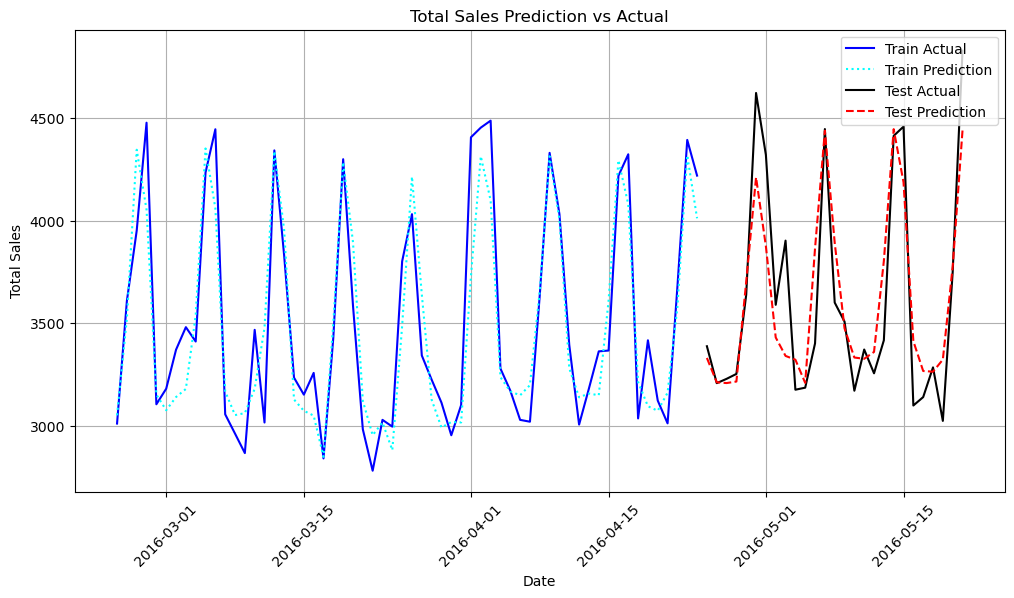

In [107]:
# Plot with required formatting
plt.figure(figsize=(12, 6))
plt.plot(train_actual.index[-60:], train_actual['items_sold_true'][-60:], label="Train Actual", color="blue")
plt.plot(train_pred.index[-60:], train_pred['items_sold'][-60:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test_actual.index, test_actual['items_sold_true'], label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred['items_sold'], label="Test Prediction", linestyle="dashed", color="red")

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


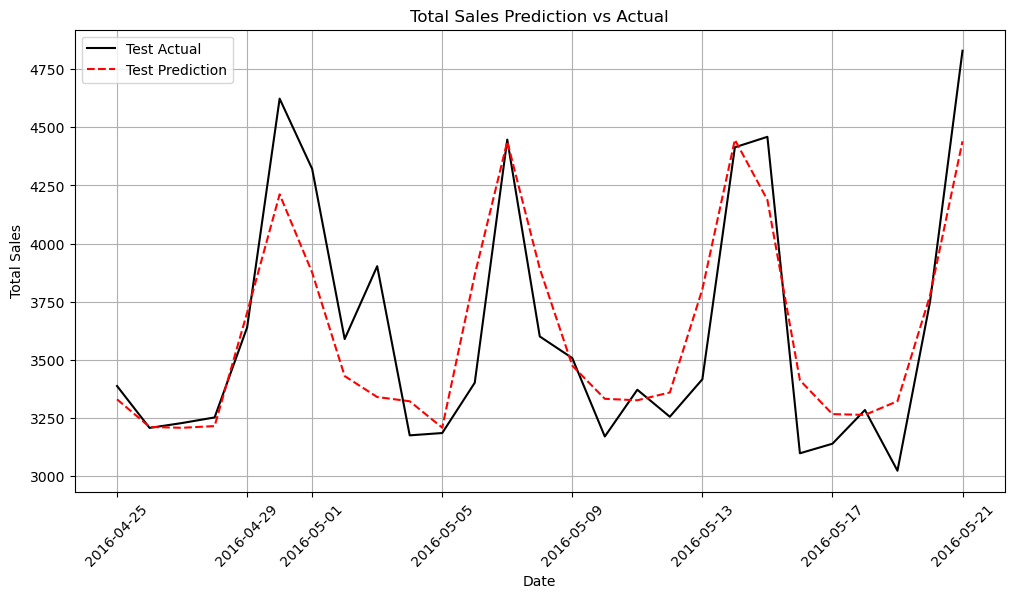

In [108]:
# Plot with required formatting
plt.figure(figsize=(12, 6))
# plt.plot(train_actual.index[-60:], train_actual['items_sold_true'][-60:], label="Train Actual", color="blue")
# plt.plot(train_pred.index[-60:], train_pred['items_sold'][-60:], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test_actual.index, test_actual['items_sold_true'], label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred['items_sold'], label="Test Prediction", linestyle="dashed", color="red")

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


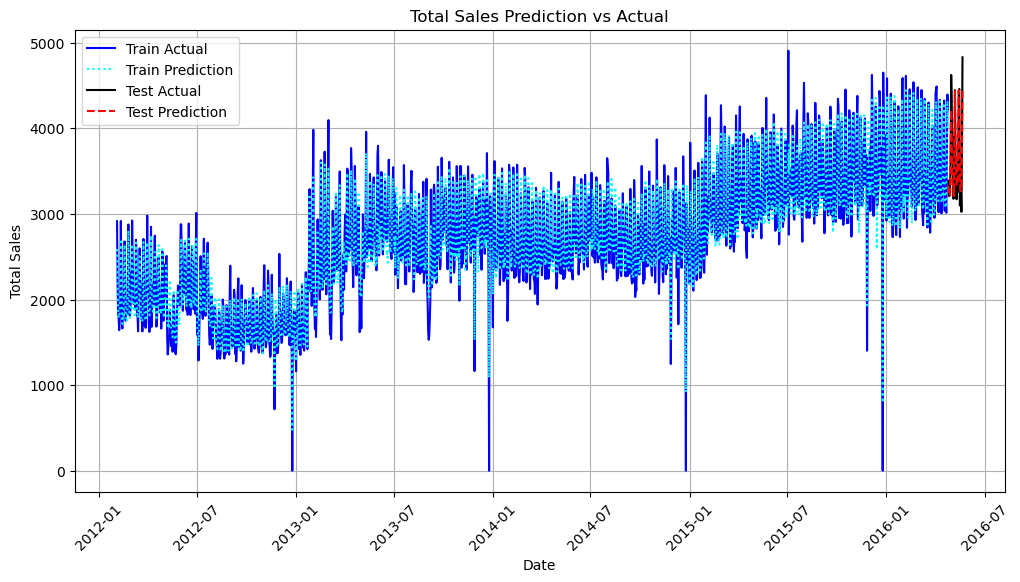

In [110]:
# Plot with required formatting
plt.figure(figsize=(12, 6))
plt.plot(train_actual.index, train_actual['items_sold_true'], label="Train Actual", color="blue")
plt.plot(train_pred.index, train_pred['items_sold'], label="Train Prediction", linestyle="dotted", color="cyan")
plt.plot(test_actual.index, test_actual['items_sold_true'], label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred['items_sold'], label="Test Prediction", linestyle="dashed", color="red")

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Total Sales Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
